In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, matthews_corrcoef

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertForSequenceClassification, BertTokenizer, BertForNextSentencePrediction
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from transformers import CamembertForSequenceClassification, CamembertTokenizer
from transformers import AlbertForSequenceClassification, AlbertTokenizer
from transformers import OpenAIGPTDoubleHeadsModel, OpenAIGPTTokenizer

from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers.optimization import AdamW

In [15]:
#It works - BERT Model
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#It works - Distil BERT
distil_bert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
distil_bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

#It works- French Language Model
camem_bert_model = CamembertForSequenceClassification.from_pretrained('camembert-base')
camem_bert_tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

#It works - Roberta Tokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base')

#It works for EPOCHS=30 - Albert Tokenizer
albert_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2')
albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

#It does not work
# tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
# model = OpenAIGPTDoubleHeadsModel.from_pretrained('openai-gpt')

#It works- GPT2 Tokenizer
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_model = GPT2LMHeadModel.from_pretrained('gpt2')

# tokenizer.add_special_tokens({'cls_token': '[CLS]', 'pad_token': '[PAD]'})
# model.resize_token_embeddings(len(tokenizer))  # Update the model embeddings with the new vocabulary size


models = [bert_model, distil_bert_model, camem_bert_model, roberta_model, albert_model, gpt_model]
tokenizers = [bert_tokenizer, distil_bert_tokenizer, camem_bert_tokenizer, roberta_tokenizer, albert_tokenizer, gpt_tokenizer]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [8]:
df = pd.read_excel('Health Related Policies-Labled 1000 Records.xlsx')

X_train = df['HealthPrivacyPolicy'][:700]
y_train = df['Label'][:700]
X_test = df['HealthPrivacyPolicy'][700:]
y_test = df['Label'][700:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(700,) (700,) (299,) (299,)


In [9]:
MAX_SEQ_LEN = 32
BATCH_SIZE = 4
NUM_EPOCHS = 1
no_decay = ['bias', 'gamma', 'beta']
count = 1

In [10]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [16]:
model = models[0]
tokenizer = tokenizers[0]

In [17]:
input_ids = []
attention_masks = []

In [18]:
for tweet in X_train:
    if model != gpt_model:
        #Only for BERT models
        encoded_data = tokenizer.encode_plus(text=tweet, max_length=512, pad_to_max_length=True)
        input_ids.append(encoded_data['input_ids'])

    else:
        #ONly FOR OpenAI-GPT and GPT2  
        tokenizer.add_special_tokens({'cls_token': '[CLS]', 'pad_token': '[PAD]'})
        # model.resize_token_embeddings(len(tokenizer))  # Update the model embeddings with the new vocabulary size

        encoded_data = tokenizer.encode_plus(text=tweet, max_length=512, pad_to_max_length=True)
        input_ids.append(encoded_data['input_ids'])
        
    #token_type_ids.append(encoded_data['token_type_ids'])
    attention_masks.append(encoded_data['attention_mask'])


# Use train_test_split to split our training data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, y_train, random_state=27, test_size=0.20)  

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=27, test_size=0.20)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\Hammad\Documents\Python_Envs\bert_trans_env\lib\site-packages\transformers\tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [20]:
print("Train Data: ", len(train_inputs), len(train_masks), len(train_labels))
print("Test Data: ", len(validation_inputs), len(validation_masks), len(validation_labels))

Train Data:  560 560 560
Test Data:  140 140 140


In [21]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

#train_token_types = torch.tensor(train_token_types)
#validation_token_types = torch.tensor(validation_token_types)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

train_labels = torch.tensor(df['Label'][:560].values)
validation_labels = torch.tensor(df['Label'][560:700].values)

# Select a batch size for training. 
batch_size = BATCH_SIZE

# Create an iterator of our data with torch DataLoader 
#train_data = TensorDataset(train_inputs, train_token_types, train_masks, train_labels)
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#validation_data = TensorDataset(validation_inputs, validation_token_types, validation_masks, validation_labels)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [23]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.0}
]

optimizer = AdamW(params=optimizer_grouped_parameters, lr=2e-5, weight_decay=0.01)


# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = NUM_EPOCHS

c:\Users\Hammad\Documents\Python_Envs\bert_trans_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
# Set our model to training mode
model.train()  
# Tracking variables
tr_loss = 0
nb_tr_examples, nb_tr_steps = 0, 0
# Train the data for one epoch
for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    #b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    #loss, _ = model(input_ids = b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_input_mask, labels=b_labels)
    #loss, _ = model(input_ids = b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_input_mask, next_sentence_label=b_labels)
    loss, _ = model(input_ids = b_input_ids, attention_mask=b_input_mask, labels=b_labels, return_dict=False)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
print("Train loss: {:.4f}".format(tr_loss/nb_tr_steps))

Train loss: 0.5092


In [25]:
# Put model in evaluation mode
model.eval()
# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
# Evaluate data for one epoch
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    #b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
    # Forward pass, calculate logit predictions
    #logits = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_input_mask) 
        logits = model(b_input_ids, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = np.array(logits[0].cpu())
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
print("Validation Accuracy: {:.4f}\n".format(eval_accuracy/nb_eval_steps))

Validation Accuracy: 0.8786



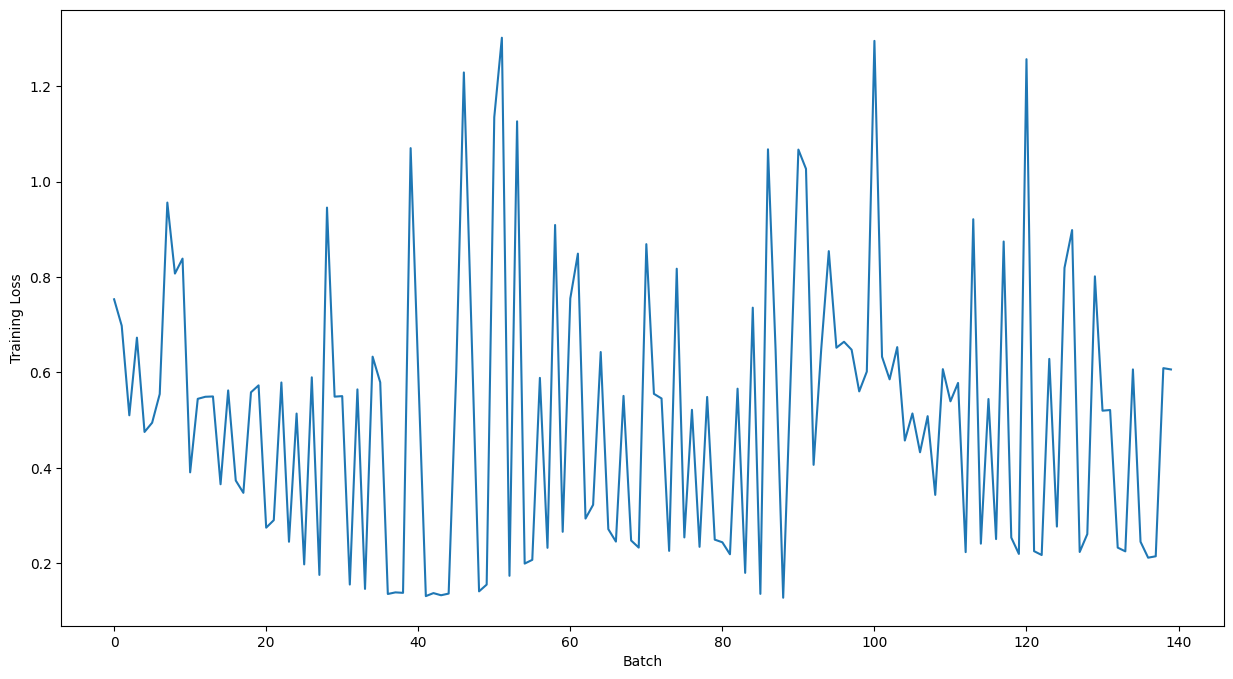

In [26]:
# plot training performance
plt.figure(figsize=(15,8))
#plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Training Loss")
plt.plot(train_loss_set)
# plt.show()
plt.savefig("model_" + str(count) + 'jpg')

In [28]:
def evaluate(model, test_inputs, token_types, test_masks, test_labels):
    # Convert all of our data into torch tensors, the required datatype for our model
    prediction_inputs = torch.tensor(test_inputs)
    #prediction_token_types = torch.tensor(token_types)
    prediction_masks = torch.tensor(test_masks)
    prediction_labels = torch.tensor(df['Label'][700:].values)

    # Select a batch size for training. 
    batch_size = BATCH_SIZE

    # Create an iterator of our data with torch DataLoader 
    #prediction_data = TensorDataset(prediction_inputs, prediction_token_types, prediction_masks, prediction_labels)
    prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

    ## Prediction on test set
    # Put model in evaluation mode
    model.eval()
    # Tracking variables 
    predictions , true_labels = [], []
    # Predict 
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        #b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up prediction
        with torch.no_grad():
          # Forward pass, calculate logit predictions
          # logits = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_input_mask)
          logits = model(b_input_ids, attention_mask=b_input_mask)
        # Move logits and labels to CPU
        logits = logits[0].cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()  
        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)
    
    # matthews_set = []
    # for i in range(len(true_labels)):
    #   matthews = matthews_corrcoef(true_labels[i],
    #                 np.argmax(predictions[i], axis=1).flatten())
    #   matthews_set.append(matthews)
      
    # Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
    flat_true_labels = [item for sublist in true_labels for item in sublist]

    scores = {
      #'matthews_corrcoef_acc': matthews_corrcoef(flat_true_labels, flat_predictions),
      'precision': precision_score(flat_true_labels, flat_predictions),
      'recall': recall_score(flat_true_labels, flat_predictions),
      'f1_score': f1_score(flat_true_labels, flat_predictions),
      'accuracy': accuracy_score(flat_true_labels, flat_predictions)
    }

    return scores

In [37]:
input_ids_test = []
attention_masks_test = []
#token_type_ids_test = []

for tweet in X_test:
    encoded_data_test = tokenizer.encode_plus(text=tweet, max_length=MAX_SEQ_LEN, pad_to_max_length=True)
    input_ids_test.append(encoded_data_test['input_ids'])
    #token_type_ids_test.append(encoded_data_test['token_type_ids'])
    attention_masks_test.append(encoded_data_test['attention_mask'])

scores = evaluate(model, input_ids_test, token_type_ids_test, attention_masks_test, y_test)
print('{:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(scores['accuracy'], scores['precision'], scores['recall'], scores['f1_score']))

c:\Users\Hammad\Documents\Python_Envs\bert_trans_env\lib\site-packages\transformers\tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


0.9298, 0.9298, 1.0000, 0.9636
